## Analyze A/B Test Results


A project that leverages inferential statistics and hypothesis testing in combination with a database of user conversion rates to determine whether a company should adopt a new web page or keep the old one.

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.


<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`. 

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df=pd.read_csv('ab_data.csv')
df.head();

b. Use the cell below to find the number of rows in the dataset.

In [3]:
df.shape

(294478, 5)

c. The number of unique users in the dataset.

In [5]:
df.user_id.nunique()

290584

d. The proportion of users converted.

In [6]:
df.converted.mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't match.

In [3]:
df_np = df.query('landing_page == "new_page"')
(df_np['group'] != "treatment").sum()

1928

In [4]:
df_op = df.query('landing_page == "old_page"')
(df_op['group'] != "control").sum()

1965

f. Do any of the rows have missing values?

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  we should figure out how we should handle these rows.  

a. They should be removed because we want to be sure about the quality of our data.

In [5]:
df1=df_np[df_np['group'] == "treatment"]
df2=df1.append(df_op[df_op['group'] == "control"],ignore_index=True);

In [6]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Clean the data.

a. How many unique **user_id**s are in **df2**?

In [12]:
df2.info()
df2.user_id.nunique()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290585 entries, 2 to 294476
Data columns (total 5 columns):
user_id         290585 non-null int64
timestamp       290585 non-null object
group           290585 non-null object
landing_page    290585 non-null object
converted       290585 non-null int64
dtypes: int64(2), object(3)
memory usage: 13.3+ MB


290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [73]:
df2[df2.user_id.duplicated()].user_id

2893    773192
Name: user_id, dtype: int64

c. What is the row information for the repeat **user_id**? 

In [14]:
df2[df2.user_id.duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [7]:
df2.drop(2893,axis=0,inplace=True)

`4.` Investigate the data as follow:

a. What is the probability of an individual converting regardless of the page they receive?

In [16]:
df2.converted.mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [75]:
df2[df2['group']=="control"].converted.mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [76]:
df2[df2['group']=="treatment"].converted.mean()

0.11880806551510564

d. What is the probability that an individual received the new page?

In [77]:
(df2['landing_page']=="new_page").mean()

0.5000619442226688

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

So far there are not enough evidence to conclude the new page may lead to more conversion. Receiving the new page was fair(p=0.5) for individuals and the conversion rate for new page is slightly smaller than the control group. Thus, we should run a hypothesis test to find out if neither page is better than another.

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

$$H_0: p_{new} - p_{old} <= 0$$


$$H_1: p_{new} - p_{old} > 0$$

or:

$H_{0}$: The likelihood of conversion for a user receiving the new page is less than or equal to the likelihood of conversion for a user receiving the old page.

$H_{1}$: The likelihood of conversion for a user receiving the new page is greater than the likelihood of conversion for a user receiving the old page

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [8]:
pn_obs = df2.query('landing_page == "new_page"').converted.mean()
pn_null = df2.converted.mean()
pn_null

0.11959708724499628

b. What is the **conversion rate** for $p_{old}$ under the null? <br>

In [9]:
po_obs = df2.query('landing_page == "old_page"').converted.mean()
po_null = df2.converted.mean()
po_null

0.11959708724499628

c. What is $n_{new}$, the number of individuals in the treatment group?

In [10]:
nn = df2.query('group == "treatment"').shape[0]
nn

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [11]:
no = df2.query('group == "control"').shape[0]
no

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [12]:
new_page_converted = np.random.choice([0,1],nn,p=[1-pn_null,pn_null])
new_page_converted.mean()

0.11922097584474571

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [13]:
old_page_converted = np.random.choice([0,1],no,p=[1-po_null,po_null])
old_page_converted.mean()

0.12069606398942688

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [14]:
p_diff = new_page_converted.mean()-old_page_converted.mean()
p_diff

-0.0014750881446811692

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

We can bootstrap to simulate the sampling distrubtion for difference in convertion rate. we can find the standard deviation of the samples to create a standard normal distribution which simulates under the null.

In [15]:
pdif=[]
size = df2.shape[0]
for _ in range(10000):
    b_samp2=df2.sample(size,replace=True)
    pnew = b_samp2.query('landing_page == "new_page"').converted.mean()
    pold = b_samp2.query('landing_page == "old_page"').converted.mean()
    pdif.append(pnew-pold)

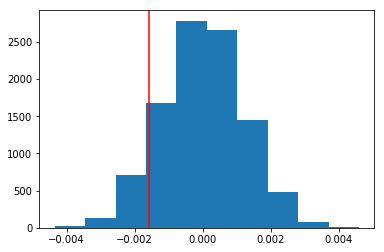

In [17]:
obs_diffs = pn_obs-po_obs
pdif=np.array(pdif)
null_vals = np.random.normal(0,pdif.std(),pdif.size)
plt.hist(null_vals);
plt.axvline(x=obs_diffs, color='r');

In [20]:
pval_norm=(null_vals>obs_diffs).mean()
pval_norm

0.9021

the code above with 'for' loop takes about 10 min to run and so it is not efficient. We can instead simulate our sampling distribution using binomial distribution as follow:

In [85]:
new_converted_simulation = \
    np.random.binomial(nn, pn_null, 10000)/nn
old_converted_simulation = \
    np.random.binomial(no, po_null, 10000)/no
p_diffs = new_converted_simulation - old_converted_simulation

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

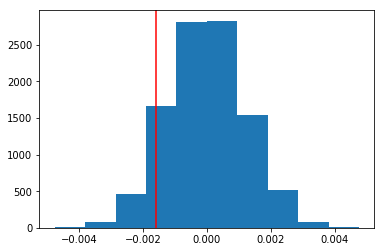

In [86]:
p_diffs=np.array(p_diffs)

plt.hist(p_diffs);
plt.axvline(x=obs_diffs, color='r');

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [87]:
pval_bi=(p_diffs>obs_diffs).mean()
pval_bi

0.9027

'''
It is p-value, the probability of the observed change in converted rate occurring or a change even more in favor of an increase in new page conversion rate given there was actually no change in converted rate.
'''

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [71]:
import statsmodels.api as sm

convert_old = df2.query('landing_page == "old_page"').converted.sum()
convert_new = df2.query('landing_page == "new_page"').converted.sum()
n_old = df2.query('landing_page == "old_page"').shape[0]
n_new = df2.query('landing_page == "new_page"').shape[0]
convert_old,convert_new, n_old, n_new

(17489, 17264, 145274, 145310)

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [77]:
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new],alternative='smaller')
z_score, p_value

(1.3109241984234394, 0.90505831275902449)

In [74]:
from scipy.stats import norm

norm.cdf(z_score)
# 0.9999999383005862 # Tells us how significant our z-score is

norm.ppf(1-(0.05/2))
# 1.959963984540054 # Tells us what our critical value at 95% confidence is

1.959963984540054

In [75]:
norm.cdf(z_score)

0.90505831275902449

We applied a one-sided z-test here(using smaller alternative which represent the alternative hypthesis according to [convert_old<convert_new] and since the A/B test in Part II was also one sided according to the null, the p-values reasonably match each other. p-value represent all the null values that are more extreme than our statistic (here:observed difference) in favor of alternative.

Since the z-score of 1.31 is within the range of the critical value, 1.96, we fail to reject the null hypothesis.

Thus, both the built-in method and the manual calculation lead to the same conclusion.

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, we will see that the result achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, Logistic regression would be approperiate in this case since our values are changing between 0 and 1.

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [139]:
import statsmodels.api as sm
df2.head(2)

,user_id,timestamp,group,landing_page,converted,new_page,old_page,control,treatment
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,0,1


In [1]:
df2=df2.join(pd.get_dummies(df2['landing_page']))
df2=df2.join(pd.get_dummies(df2['group']))
df2.head()

In [146]:
df2.rename(columns={'treatment':'ab_page'},inplace=True);

c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [142]:
df2.drop(['old_page','new_page','control'],axis=1,inplace=True)


In [153]:
df2.tail(2)

,user_id,timestamp,group,landing_page,converted,ab_page,intercept
294475,734608,2017-01-22 11:45:03.439544,control,old_page,0,0,1
294476,697314,2017-01-15 01:20:28.957438,control,old_page,0,0,1


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [156]:
df2['intercept']=1
lm=sm.Logit(df2['converted'],df2[['intercept','ab_page']])
res=lm.fit()
res.summary()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Tue, 05 Feb 2019   Pseudo R-squ.:               8.077e-06
Time:                        03:48:35   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. 

the p-value is 0.19 in here while it was about 0.9 in part II.

The null hypothesis of the logistic regression is that there is no relation between the type of page and convertion rate; and the alternative is that there is relationship somehow. it merely predicts a difference in conversion rate due to page type. Thus, different hypothese give different p-values between part II and part III.



f. 

Including additional factors may make the model more predictive, yielding greater understanding. It may also result in business insights that would not have been evident in this simpler anlysis. For example, it would be possible to have different versions of the website for different locations. It is likely that people from different countries might have different tastes in website layout.

Possible disadvantages of additional factors include increased risk of human error, especially misinterpretation, as well as possibly obscuring the message the data is really trying to tell (decreasing the so-called signal-to-noise ratio).

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. we will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  we should first create dummy variables for these country columns.

In [178]:
dfc=pd.read_csv('countries.csv')
dfc.head();

In [177]:
df3=pd.merge(df2,dfc,on='user_id');

In [180]:
df3=df3.join(pd.get_dummies(df3['country']))

In [191]:
df3.head(2)

,user_id,timestamp,group,landing_page,converted,ab_page,intercept,country,CA,UK,US,CA_np
0,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,0,1,0
1,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,0,1,0


In [182]:
lm1=sm.Logit(df3['converted'],df3[['intercept','UK','US']])
res1=lm1.fit()
res1.summary()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Tue, 05 Feb 2019   Pseudo R-squ.:               1.521e-05
Time:                        04:37:14   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0375      0.026    -78.364      0.000      -2.088      -1.987
UK             0.0507      0.028      1.786      0.074      -0.005       0.106
US             0.0408      0.027      1.518      0.129      -0.012       0.093
==============================================================================
"""

In [185]:
np.exp(0.0507),np.exp(0.0408)

(1.0520072437650141, 1.0416437559600236)

The p-values are 0.074, 0.129, so we fail to reject the null hypothesis and so we can say the effect of country on covertion rate is not statistically significant.

According to the exponential values of the UK and US coefficients we can say that people of UK and US are 1.05 and 1.04 times as likely as canadian to convert, respectively. However these are small differences and it can't be clearly said that difefrence in countries is practically significant.

h. Though we have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [192]:
df3['CA_np']=df3['ab_page']*df3['CA']
df3['UK_np']=df3['ab_page']*df3['UK']
df3['US_np']=df3['ab_page']*df3['US']

In [199]:
df3.head();

In [193]:
lm2=sm.Logit(df3['converted'],df3[['intercept','UK_np','US_np']])
res2=lm2.fit()
res2.summary()

Optimization terminated successfully.
         Current function value: 0.366117
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Tue, 05 Feb 2019   Pseudo R-squ.:               1.082e-05
Time:                        05:11:50   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.3164
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9926      0.008   -252.910      0.000      -2.008      -1.977
UK_np          0.0112      0.018      0.626      0.532      -0.024       0.046
US_np         -0.0144      0.012     -1.155      0.248      -0.039       0.010
==============================================================================
"""

Similarly the p-values are greater than 0.05 and so we fail to reject that null hypothesis saying there is no relation between treated countries and the convertion rate. Thus the interaction terms have no significant effect on convertion.

## Conclusion

Based on the A/B test performed on the relation between convertion rate and other tested variables, we can say the new page does not have a statistically significant influence on conversions. Hence it is recommended that the e-commerce company keep using the old page, note that no other factors was available other than the ones considered here.

In [22]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])